# Icclim indices - R10mm (Number of heavy precipitation days (Precip >=10mm))

Assessment of model icclim indices

In [1]:
import warnings
warnings.filterwarnings('ignore')
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
import cmocean
import cartopy.crs as ccrs
import xarray as xr
import cmocean
sys.path.append('/g/data/xv83/users/at2708/bias_adjustment/evaluation/npcp/results')
import utils

In [2]:
def average_index(da):
    """Calculate the average index"""
    da_mean = da.mean(dim='time')

    return da_mean

In [3]:
# Data collection and processing
def get_data(gcm, rcm, task, index):
    """Get processed icclim data"""
    tasks={
        "historical":{
            "start_date": "19800101",
            "end_date": "20191231",
            "start_date_train": "19800101",
            "end_date_train": "20191231"
        },
        "xvalidation":{
            "start_date": "19900101",
            "end_date": "20191231",
            "start_date_train": "19600101",
            "end_date_train": "19891231"
        },
        "projection":{
            "start_date": "20600101",
            "end_date": "20991231",
            "start_date_train": "19800101",
            "end_date_train": "20191231"
        },
        "agcd_training":{
            "start_date": "19600101",
            "end_date": "19891231",
        }
    }
    assert gcm in ['CSIRO-ACCESS-ESM1-5']
    assert rcm in ['BOM-BARPA-R', 'CSIRO-CCAM-2203', 'UQ-DES-CCAM-2105']
    assert task in ['historical', 'xvalidation']

    def get_path_details(path, index):
        parts = path.split('_')
        method_part = parts[9]
        method_tokens = method_part.split('-')
        method = next((token for token in method_tokens if token), None)
        if index=='R10mm' or index=='R20mm' or index=='R95pTOT' or index=='R99pTOT':
            method_amend="multiplicative-monthly"
            interp="linear"
            q="q100"
            if method=='qdm':
                q="q1000"
                method_amend="multiplicative"
                interp="nearest"
        else:
            method_amend="additive-monthly"
            interp="nearest"
            q="q100"
        return method_amend, interp, q
    
    da_dict = {}
        
    base_dir = '/g/data/ia39/npcp/data/icclim/'+index+'/'+index+'_NPCP-20i_'
       
    if task == 'historical' or task == 'xvalidation':  
        # AGCD
        path = base_dir+'AGCD_v1-0-1_day_'+tasks[task]['start_date']+'-'+tasks[task]['end_date']+'.nc'
        da_dict['agcd'] = xr.open_dataset(path)[index]
        
    if task == 'xvalidation':
        # AGCD training 
        path = base_dir+'AGCD_v1-0-1_day_'+tasks['agcd_training']['start_date']+'-'+tasks['agcd_training']['end_date']+'.nc'
        da_dict['agcd_training'] = xr.open_dataset(path)[index]  
        
    if task == 'projection' or task == 'xvalidation':  
        # QDM GCM 
        path_base = base_dir+gcm+'_ssp370_r6i1p1f1_GCM_v1_day_'+tasks[task]['start_date']+'-'+tasks[task]['end_date']+'_qdm-'
        method_amend, interp, q = get_path_details(path_base, index)
        # print(method_amend, interp, q)
        path = path_base+method_amend+'-'+q+'-'+interp+'-AGCD-'+tasks[task]['start_date_train']+'-'+tasks[task]['end_date_train']+'.nc'
        da_dict['gcm_qdm'] = xr.open_dataset(path)[index]
        
        # QDM RCMs
        path_base=base_dir+gcm+'_ssp370_r6i1p1f1_'+rcm+'_v1_day_'+tasks[task]['start_date']+'-'+tasks[task]['end_date']+'_qdm-'
        method_amend, interp, q = get_path_details(path_base, index)
        # print(method_amend, interp, q)
        path = path_base+method_amend+'-'+q+'-'+interp+'-AGCD-'+tasks[task]['start_date_train']+'-'+tasks[task]['end_date_train']+'.nc'
        da_dict['rcm_qdm'] = xr.open_dataset(path)[index]

    # GCM raw
    path = base_dir+gcm+'_ssp370_r6i1p1f1_GCM_latest_day_'+tasks[task]['start_date']+'-'+tasks[task]['end_date']+'.nc'
    da_dict['gcm_raw'] = xr.open_dataset(path)[index]
    
    # RCM raw
    path = base_dir+gcm+'_ssp370_r6i1p1f1_'+rcm+'_v1_day_'+tasks[task]['start_date']+'-'+tasks[task]['end_date']+'.nc'
    da_dict['rcm_raw'] = xr.open_dataset(path)[index]

    # ECDFM GCM 
    path_base=base_dir+gcm+'_ssp370_r6i1p1f1_GCM_v1_day_'+tasks[task]['start_date']+'-'+tasks[task]['end_date']+'_ecdfm-'
    method_amend, interp, q = get_path_details(path_base, index)
    # print(method_amend, interp, q)
    path = path_base+method_amend+'-'+q+'-'+interp+'-AGCD-'+tasks[task]['start_date_train']+'-'+tasks[task]['end_date_train']+'.nc'
    da_dict['gcm_ecdfm'] = xr.open_dataset(path)[index]
    
    # ECDFM RCMs
    path_base=base_dir+gcm+'_ssp370_r6i1p1f1_'+rcm+'_v1_day_'+tasks[task]['start_date']+'-'+tasks[task]['end_date']+'_ecdfm-'
    method_amend, interp, q = get_path_details(path_base, index)
    # print(method_amend, interp, q)
    path = path_base+method_amend+'-'+q+'-'+interp+'-AGCD-'+tasks[task]['start_date_train']+'-'+tasks[task]['end_date_train']+'.nc'
    da_dict['rcm_ecdfm'] = xr.open_dataset(path)[index]
    
    # QME RCMs
    path = base_dir+gcm+'_ssp370_r6i1p1f1_'+rcm+'_v1_day_'+tasks[task]['start_date']+'-'+tasks[task]['end_date']+'_qme-AGCD-'+tasks[task]['start_date_train']+'-'+tasks[task]['end_date_train']+'.nc'
    da_dict['rcm_qme'] = xr.open_dataset(path)[index]
    lats = np.round(np.arange(-44, -9.9, 0.2), decimals=1)
    if np.allclose(da_dict['rcm_qme']['lat'].values, lats, rtol=1e-05, atol=1e-08, equal_nan=True):
        lat_attrs = da_dict['rcm_qme']['lat'].attrs
        da_dict['rcm_qme'] = da_dict['rcm_qme'].assign_coords({'lat': lats})
        da_dict['rcm_qme'].attrs = lat_attrs
    lons = np.round(np.arange(112, 154.01, 0.2), decimals=1)
    if np.allclose(da_dict['rcm_qme']['lon'].values, lons, rtol=1e-05, atol=1e-08, equal_nan=True):
        lon_attrs = da_dict['rcm_qme']['lon'].attrs
        da_dict['rcm_qme'] = da_dict['rcm_qme'].assign_coords({'lon': lons})
        da_dict['rcm_qme'].attrs = lon_attrs

    return da_dict


In [4]:
# Plotting values
def plot_metric(ax, da, cmap, levels, index, model_name, ob_fractions=None):
    """Plot the PT index for a particular model"""
    data = average_index(da)
    data = utils.clip_data(data, utils.get_aus_shape())
    if ob_fractions is not None:
        data = utils.mask_by_pr_ob_fraction(data, ob_fractions, threshold=0.9)    

    data.plot(
        ax=ax,
        transform=ccrs.PlateCarree(),
        cmap=cmap,
        levels=levels,
        extend='both',
        cbar_kwargs={'label': index},
    )
    ax.set_title(model_name)
    ax.coastlines()


def plot_values(gcm, rcm, task, index, cmap, levels, outfile=None):
    
    da_dict = get_data(gcm, rcm, task, index)

    """Plot the index for each model/method"""

    ncols = 5 if task == 'xvalidation' else 4
    plot_nums = np.arange(1, (ncols * 2) + 1)
    
    if index=='R10mm' or index=='R20mm' or index=='R95pTOT' or index=='R99pTOT':
        ob_fractions = utils.get_pr_weights(gcm, task)
    else:
        ob_fractions = None
    
    fig = plt.figure(figsize=[7 * ncols, 10])
    
    # GCM bias indexection
    plot_index = 0
    ax_gcm1 = fig.add_subplot(2, ncols, plot_nums[plot_index], projection=ccrs.PlateCarree())
    plot_metric(
        ax_gcm1, da_dict['gcm_raw'], cmap, levels, index, gcm, ob_fractions=ob_fractions,
    )
    plot_index = plot_index + 1
    ax_gcm2 = fig.add_subplot(2, ncols, plot_nums[plot_index], projection=ccrs.PlateCarree())
    plot_metric(
        ax_gcm2,  da_dict['gcm_ecdfm'], cmap, levels, index, f'{gcm} (ecdfm)', ob_fractions=ob_fractions,
    )
    
    plot_index = plot_index + 1   # blank space

    if task == 'xvalidation':
        plot_index = plot_index + 1
        ax_gcm4 = fig.add_subplot(2, ncols, plot_nums[plot_index], projection=ccrs.PlateCarree())
        plot_metric(
            ax_gcm4, da_dict['gcm_qdm'],  cmap, levels, index, f'{gcm} (qdm)', ob_fractions=ob_fractions,
        )

    plot_index = plot_index + 1
    ax_obs = fig.add_subplot(2, ncols, plot_nums[plot_index], projection=ccrs.PlateCarree())
    plot_metric(ax_obs, da_dict['agcd'], cmap, levels, index, 'AGCD', ob_fractions=ob_fractions)
        
    # RCM bias indexection
    plot_index = plot_index + 1
    ax_rcm1 = fig.add_subplot(2, ncols, plot_nums[plot_index], projection=ccrs.PlateCarree())
    plot_metric(
        ax_rcm1, da_dict['rcm_raw'], cmap, levels, index, f'{rcm} (raw)', ob_fractions=ob_fractions,
    )
    
    plot_index = plot_index + 1
    ax_rcm2 = fig.add_subplot(2, ncols, plot_nums[plot_index], projection=ccrs.PlateCarree())
    plot_metric(
        ax_rcm2, da_dict['rcm_ecdfm'], cmap, levels, index, f'{rcm} (ecdfm)', ob_fractions=ob_fractions,
    )
    
    plot_index = plot_index + 1
    ax_rcm3 = fig.add_subplot(2, ncols, plot_nums[plot_index], projection=ccrs.PlateCarree())
    plot_metric(
        ax_rcm3, da_dict['rcm_qme'], cmap, levels, index, f'{rcm} (qme)', ob_fractions=ob_fractions,
    )
    if task == 'xvalidation':
        plot_index = plot_index + 1
        ax_rcm4 = fig.add_subplot(2, ncols, plot_nums[plot_index], projection=ccrs.PlateCarree())
        plot_metric(
            ax_rcm4, da_dict['rcm_qdm'], cmap, levels, index, f'{rcm} (qdm)', ob_fractions=ob_fractions,
        )

        plot_index = plot_index + 1
        ax_rcm5 = fig.add_subplot(2, ncols, plot_nums[plot_index], projection=ccrs.PlateCarree())
        plot_metric(
            ax_rcm5, da_dict['agcd_training'], cmap, levels, index, f'AGCD (training data)', ob_fractions=ob_fractions,
        )
        

    if gcm == 'ECMWF-ERA5':
        start_year = '2000' if task == 'xvalidation' else '1980'
    else:
        start_year = '1990' if task == 'xvalidation' else '1980'
    
    plt.suptitle(f'Annual mean {start_year}-2019 '+index, fontsize='x-large')
    if outfile:
        print(outfile)
        plt.savefig(outfile+f'{index}-values_task-{task}_{gcm}_{rcm}.png', dpi=300, bbox_inches='tight')
    plt.show()


In [5]:
# Plotting bias
def plot_bias(ax, da_obs, da_model, cmap, levels, index, model_name, ob_fractions=None):
    """Plot the bias for a particular model"""
    index_model = average_index(da_model)
    index_obs = average_index(da_obs)
    
    bias = index_model - index_obs
    bias = utils.clip_data(bias, utils.get_aus_shape())
    if ob_fractions is not None:
        bias = utils.mask_by_pr_ob_fraction(bias, ob_fractions, threshold=0.9)    
    mae = np.nanmean(np.abs(bias)) 

    bias.plot(
        ax=ax,
        transform=ccrs.PlateCarree(),
        cmap=cmap,
        levels=levels,
        extend='both',
        cbar_kwargs={'label': index},
    )
    ax.text(0.02, 0.02, f'MAE: {mae:.2f}', transform=ax.transAxes, fontsize='large')
    ax.set_title(model_name)
    ax.coastlines()
    
def plot_comparison(gcm, rcm, task, index, cmap, levels, outfile=None):
    """Plot the complete comparison"""

    da_dict = get_data(gcm, rcm, task, index)

    ncols = 5 if task == 'xvalidation' else 3
    plot_nums = np.arange(1, (ncols * 2) + 1)
    
    if index=='R10mm' or index=='R20mm' or index=='R95pTOT' or index=='R99pTOT':
        ob_fractions = utils.get_pr_weights(gcm, task)
    else:
        ob_fractions = None    
    fig = plt.figure(figsize=[7 * ncols, 10])
    
    # GCM bias correction
    plot_index = 0
    ax_gcm1 = fig.add_subplot(2, ncols, plot_nums[plot_index], projection=ccrs.PlateCarree())
    plot_bias(
        ax_gcm1, da_dict['agcd'], da_dict['gcm_raw'], cmap, levels, index, gcm, ob_fractions=ob_fractions,
    )
    plot_index = plot_index + 1
    ax_gcm2 = fig.add_subplot(2, ncols, plot_nums[plot_index], projection=ccrs.PlateCarree())
    plot_bias(
        ax_gcm2, da_dict['agcd'], da_dict['gcm_ecdfm'], cmap, levels, index, f'{gcm} (ecdfm)', ob_fractions=ob_fractions,
    )
    
    plot_index = plot_index + 1   # blank space

    if task == 'xvalidation':
        plot_index = plot_index + 1
        ax_gcm4 = fig.add_subplot(2, ncols, plot_nums[plot_index], projection=ccrs.PlateCarree())
        plot_bias(
            ax_gcm4, da_dict['agcd'],da_dict['gcm_qdm'], cmap, levels, index, f'{gcm} (qdm)', ob_fractions=ob_fractions,
        )
        plot_index = plot_index + 1

    # RCM bias correction
    plot_index = plot_index + 1
    ax_rcm1 = fig.add_subplot(2, ncols, plot_nums[plot_index], projection=ccrs.PlateCarree())
    plot_bias(
        ax_rcm1, da_dict['agcd'],  da_dict['rcm_raw'], cmap, levels, index, f'{rcm} (raw)', ob_fractions=ob_fractions,
    )
    
    plot_index = plot_index + 1
    ax_rcm2 = fig.add_subplot(2, ncols, plot_nums[plot_index], projection=ccrs.PlateCarree())
    plot_bias(
        ax_rcm2, da_dict['agcd'], da_dict['rcm_ecdfm'], cmap, levels, index, f'{rcm} (ecdfm)', ob_fractions=ob_fractions,
    )
    
    plot_index = plot_index + 1
    ax_rcm3 = fig.add_subplot(2, ncols, plot_nums[plot_index], projection=ccrs.PlateCarree())
    plot_bias(
        ax_rcm3, da_dict['agcd'], da_dict['rcm_qme'], cmap, levels, index, f'{rcm} (qme)', ob_fractions=ob_fractions,
    )
    if task == 'xvalidation':
        plot_index = plot_index + 1
        ax_rcm4 = fig.add_subplot(2, ncols, plot_nums[plot_index], projection=ccrs.PlateCarree())
        plot_bias(
            ax_rcm4, da_dict['agcd'], da_dict['rcm_qdm'], cmap, levels, index, f'{rcm} (qdm)', ob_fractions=ob_fractions,
        )
        
        plot_index = plot_index + 1
        ax_rcm5 = fig.add_subplot(2, ncols, plot_nums[plot_index], projection=ccrs.PlateCarree())
        plot_bias(
            ax_rcm5, da_dict['agcd'], da_dict['agcd_training'], cmap, levels, index, f'AGCD (training data)', ob_fractions=ob_fractions,
        )
        

    if gcm == 'ECMWF-ERA5':
        start_year = '2000' if task == 'xvalidation' else '1980'
    else:
        start_year = '1990' if task == 'xvalidation' else '1980'
    
    plt.suptitle(f'Bias (model minus obs) in the annual mean {start_year}-2019 '+index, fontsize='x-large')
    if outfile:
        print(outfile)
        plt.savefig(outfile+f'{index}-bias_task-{task}_{gcm}_{rcm}.png', dpi=300, bbox_inches='tight')
    plt.show()

## task-historical

Bias corrected data for the 1980-2019 period, using 1980-2019 as a training period.

#### ERA5

In [6]:
#gcm = 'ECMWF-ERA5'
#task = 'historical'
# index = 'R10mm'

In [7]:
#rcm = 'BOM-BARPA-R'
# plot_values()
# plot_comparison()

In [8]:
#rcm = 'CSIRO-CCAM-2203'
# plot_values()
# plot_comparison()

In [9]:
#rcm = 'UQ-DES-CCAM-2105'
# plot_values()
# plot_comparison()

#### ACCESS-ESM1-5

In [10]:
gcm = 'CSIRO-ACCESS-ESM1-5'
task = 'historical'
rcm = 'BOM-BARPA-R'
index = 'R10mm'
levels_values=[5,10,15,20,25,30]
cmap_values=cmocean.cm.rain
levels_bias=[-5,-4,-3,-2,-1,1,2,3,4,5]
cmap_bias='BrBG'
outfile='/g/data/xv83/users/at2708/bias_adjustment/evaluation/'

/g/data/xv83/users/at2708/bias_adjustment/evaluation/


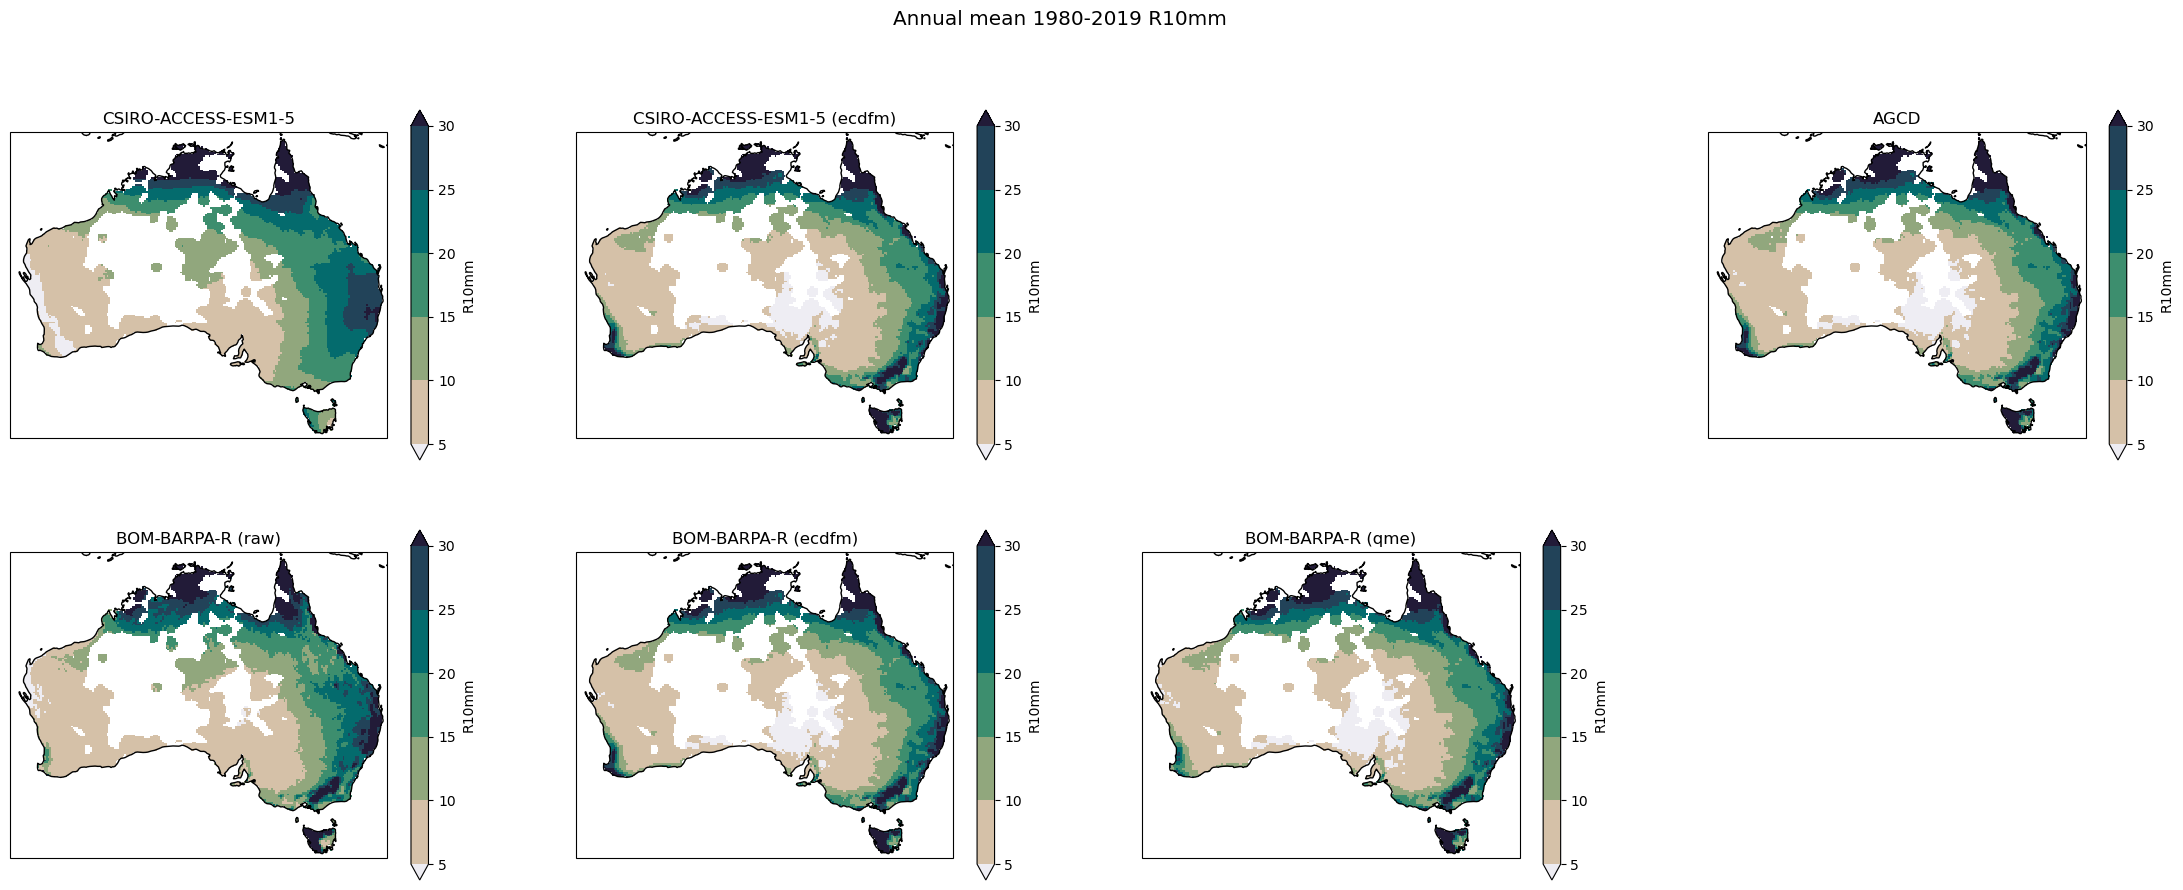

In [11]:
plot_values(gcm, rcm, task, index, cmap=cmap_values, levels=levels_values, outfile=outfile)

/g/data/xv83/users/at2708/bias_adjustment/evaluation/


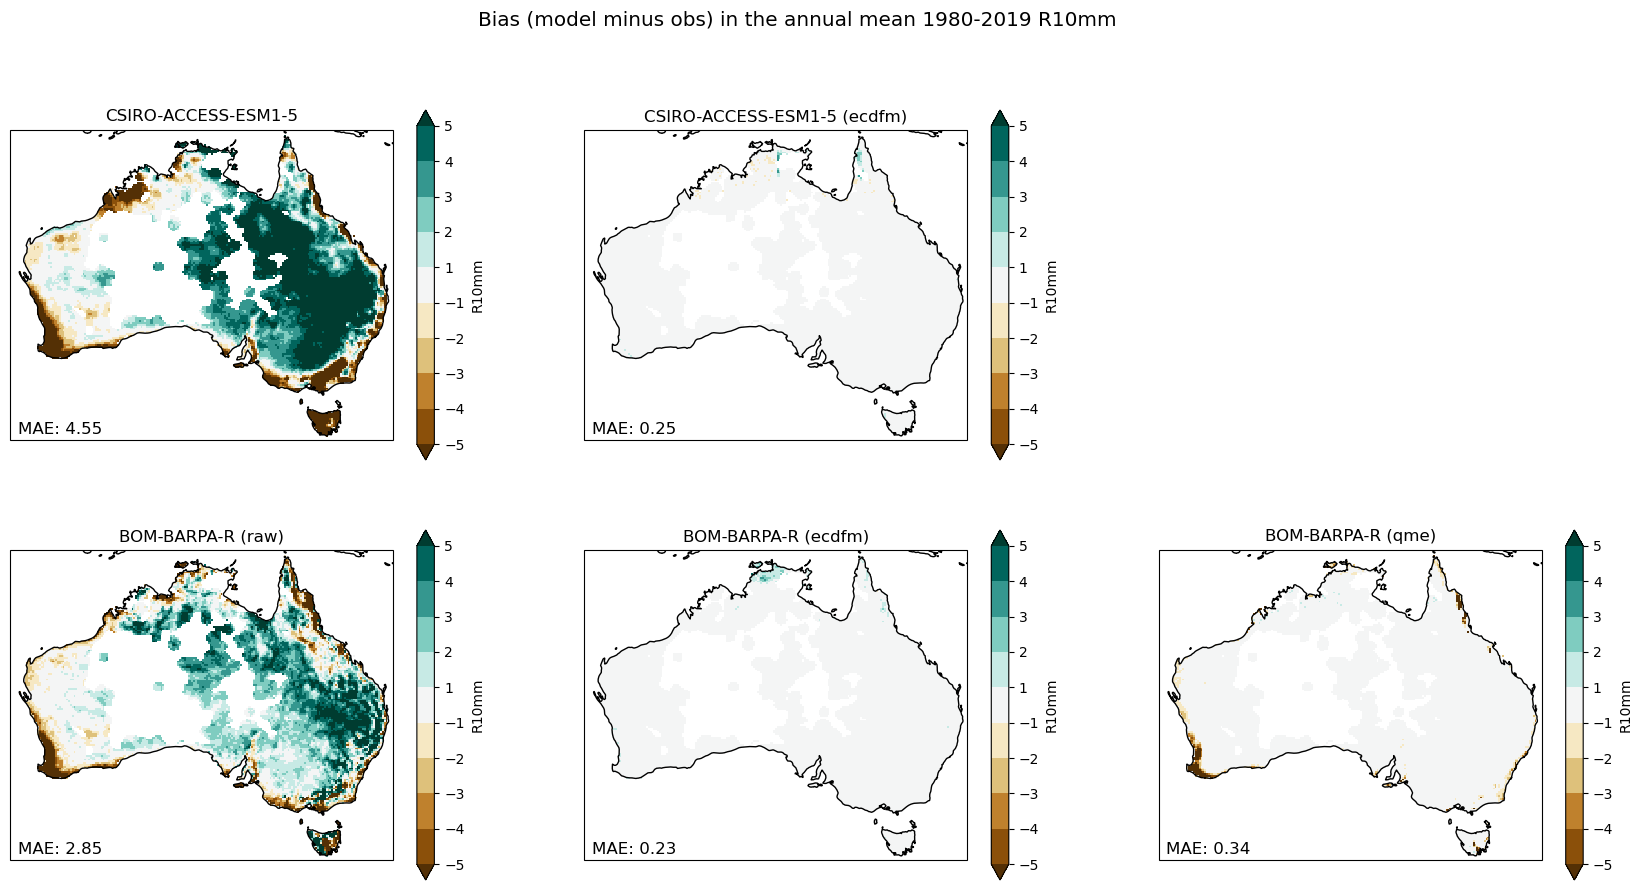

In [12]:
plot_comparison(gcm, rcm, task, index, cmap=cmap_bias, levels=levels_bias, outfile=outfile)

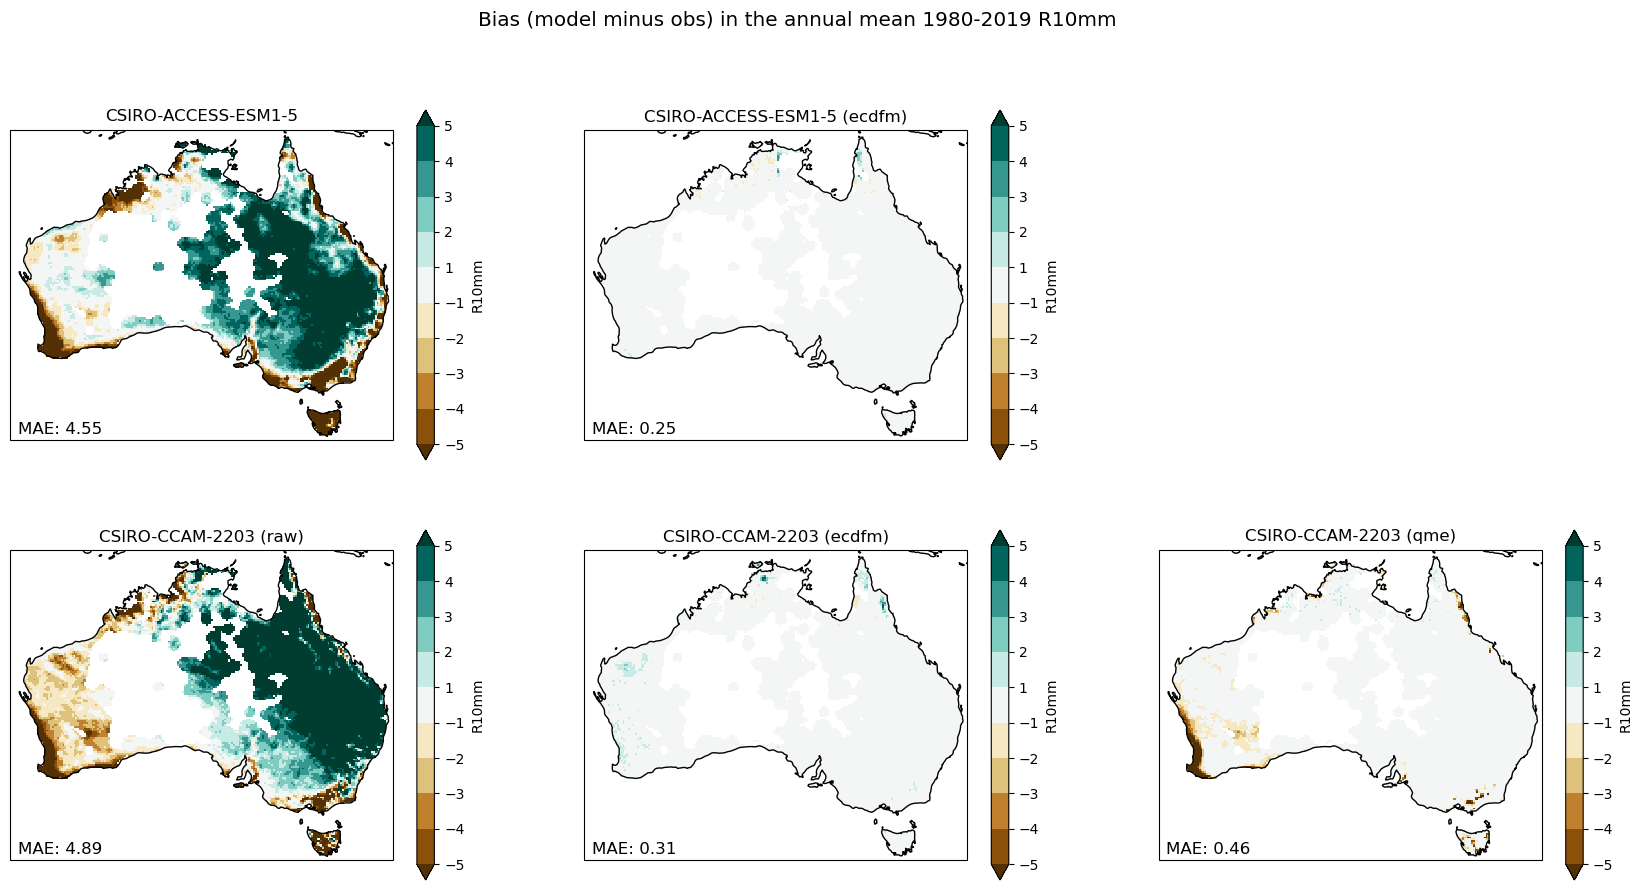

In [13]:
rcm = 'CSIRO-CCAM-2203'
plot_comparison(gcm, rcm, task, index, cmap=cmap_bias, levels=levels_bias)

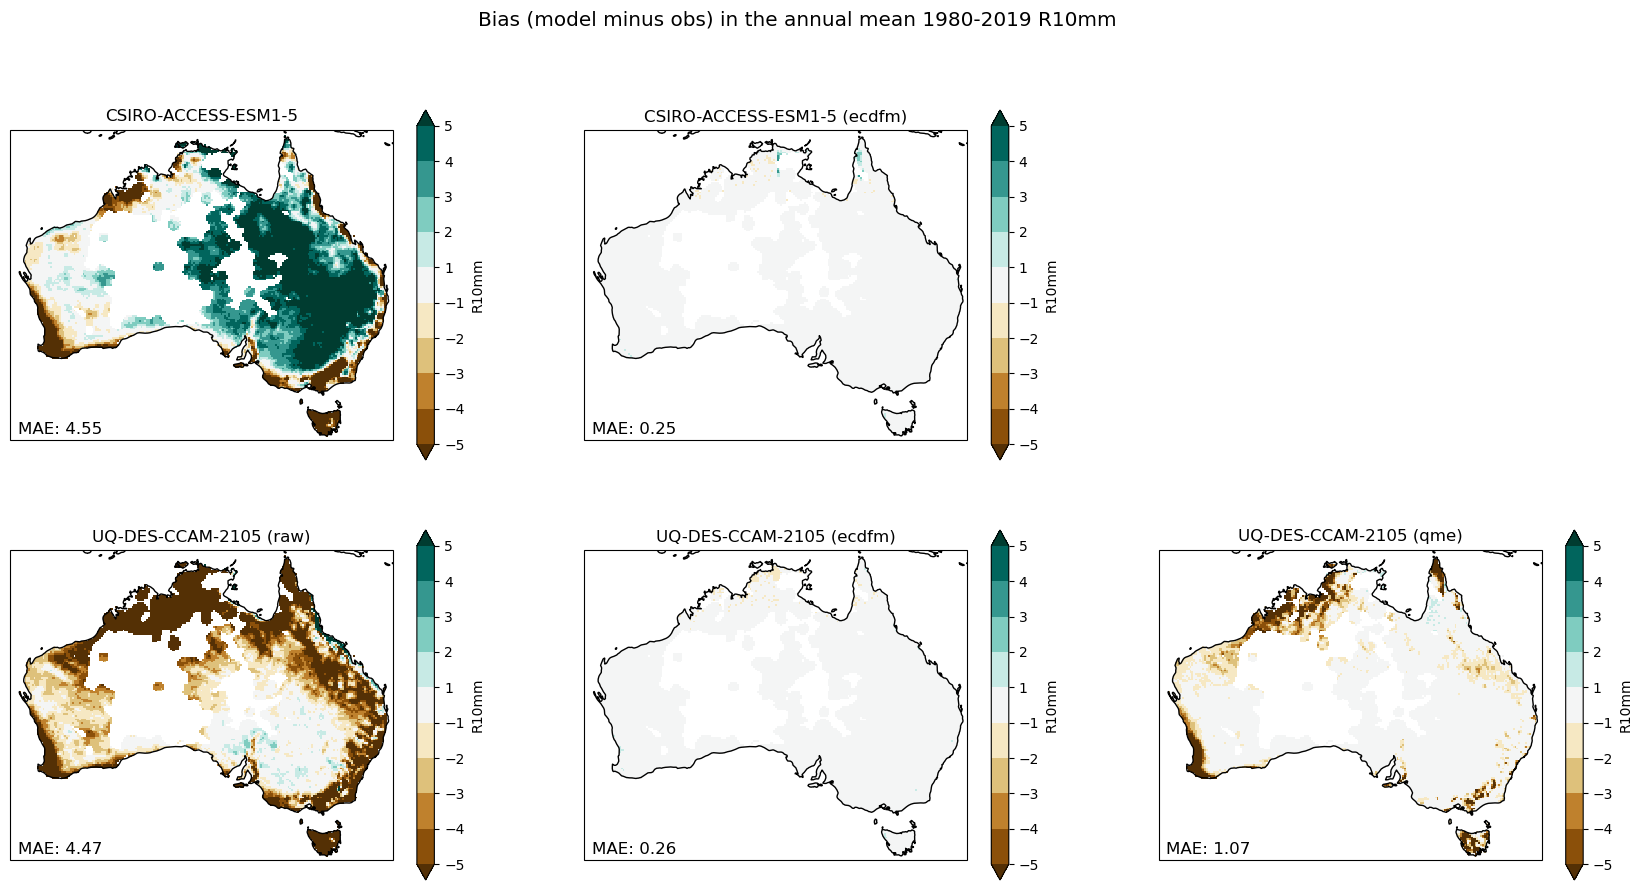

In [14]:
rcm = 'UQ-DES-CCAM-2105'
plot_comparison(gcm, rcm, task, index, cmap=cmap_bias, levels=levels_bias)

## task-xvalidation

#### ERA5

Bias corrected data for the 2000-2019 period, using 1980-1999 as a training period.

In [15]:
#gcm = 'ECMWF-ERA5'
#task = 'xvalidation'

In [16]:
#rcm = 'BOM-BARPA-R'
# plot_values()
# plot_comparison()

In [17]:
#rcm = 'CSIRO-CCAM-2203'
# plot_values()
# plot_comparison()

In [18]:
#rcm = 'UQ-DES-CCAM-2105'
# plot_values()
# plot_comparison()

#### ACCESS-ESM1-5

Bias corrected data for the 1990-2019 period, using 1960-1989 as a training period.

In [19]:
gcm = 'CSIRO-ACCESS-ESM1-5'
task = 'xvalidation'
rcm = 'BOM-BARPA-R'

/g/data/xv83/users/at2708/bias_adjustment/evaluation/


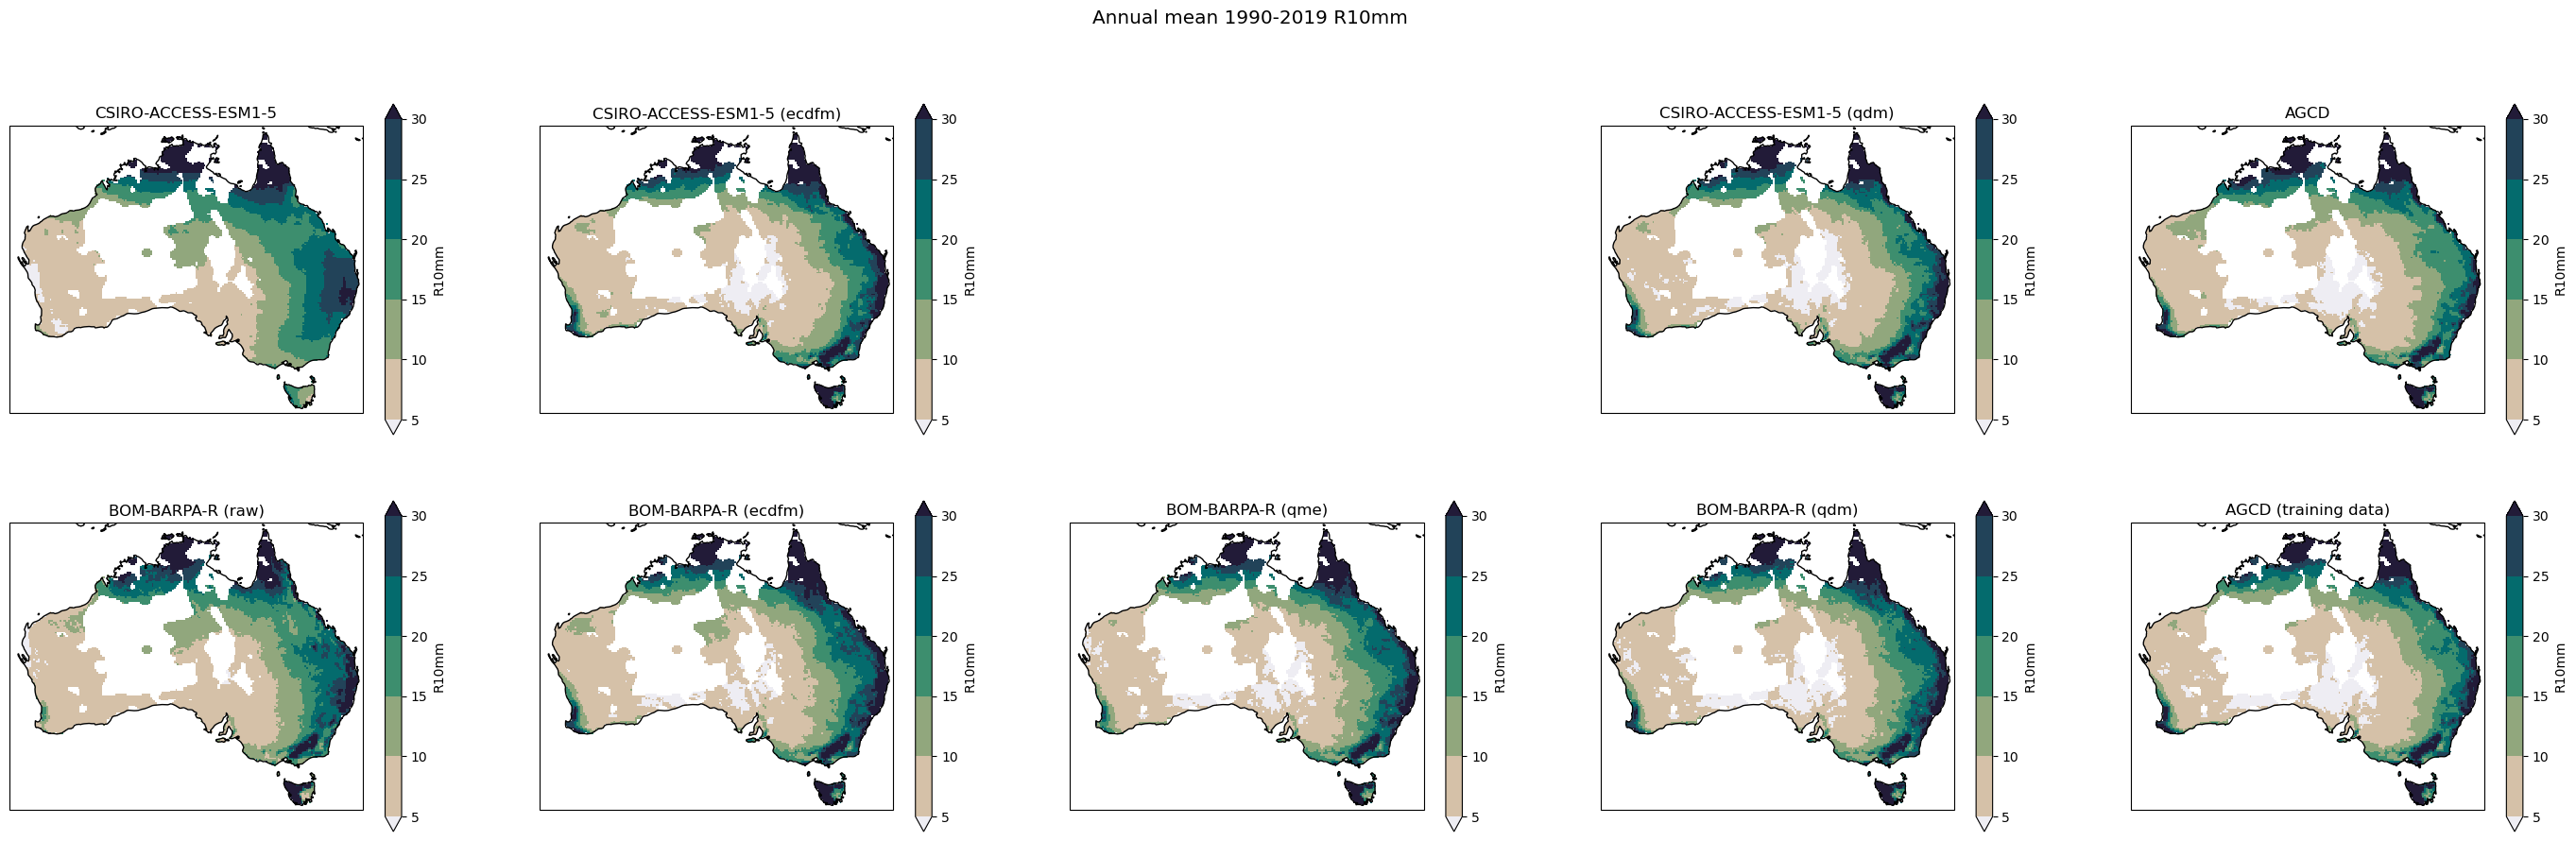

In [20]:
plot_values(gcm, rcm, task, index, cmap=cmap_values, levels=levels_values, outfile=outfile)

/g/data/xv83/users/at2708/bias_adjustment/evaluation/


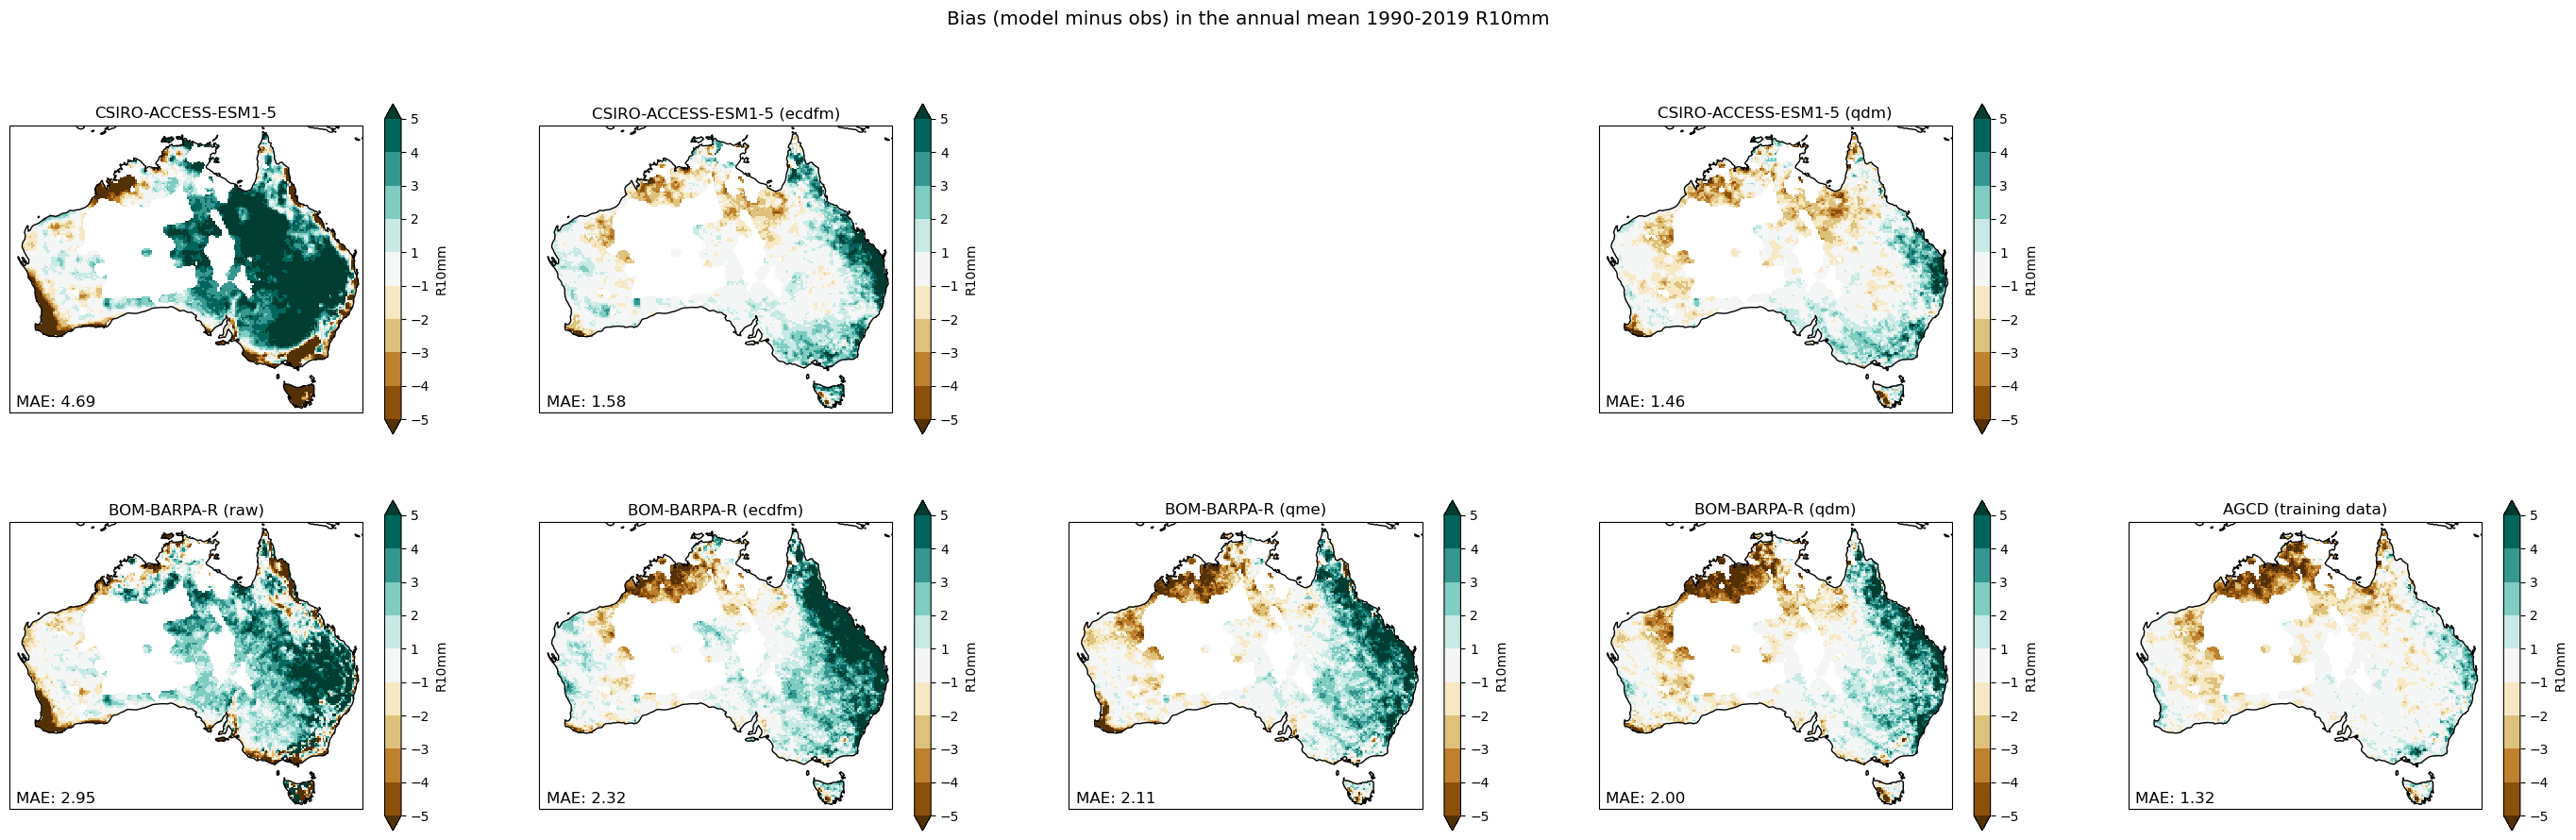

In [21]:
plot_comparison(gcm, rcm, task, index, cmap=cmap_bias, levels=levels_bias, outfile=outfile)

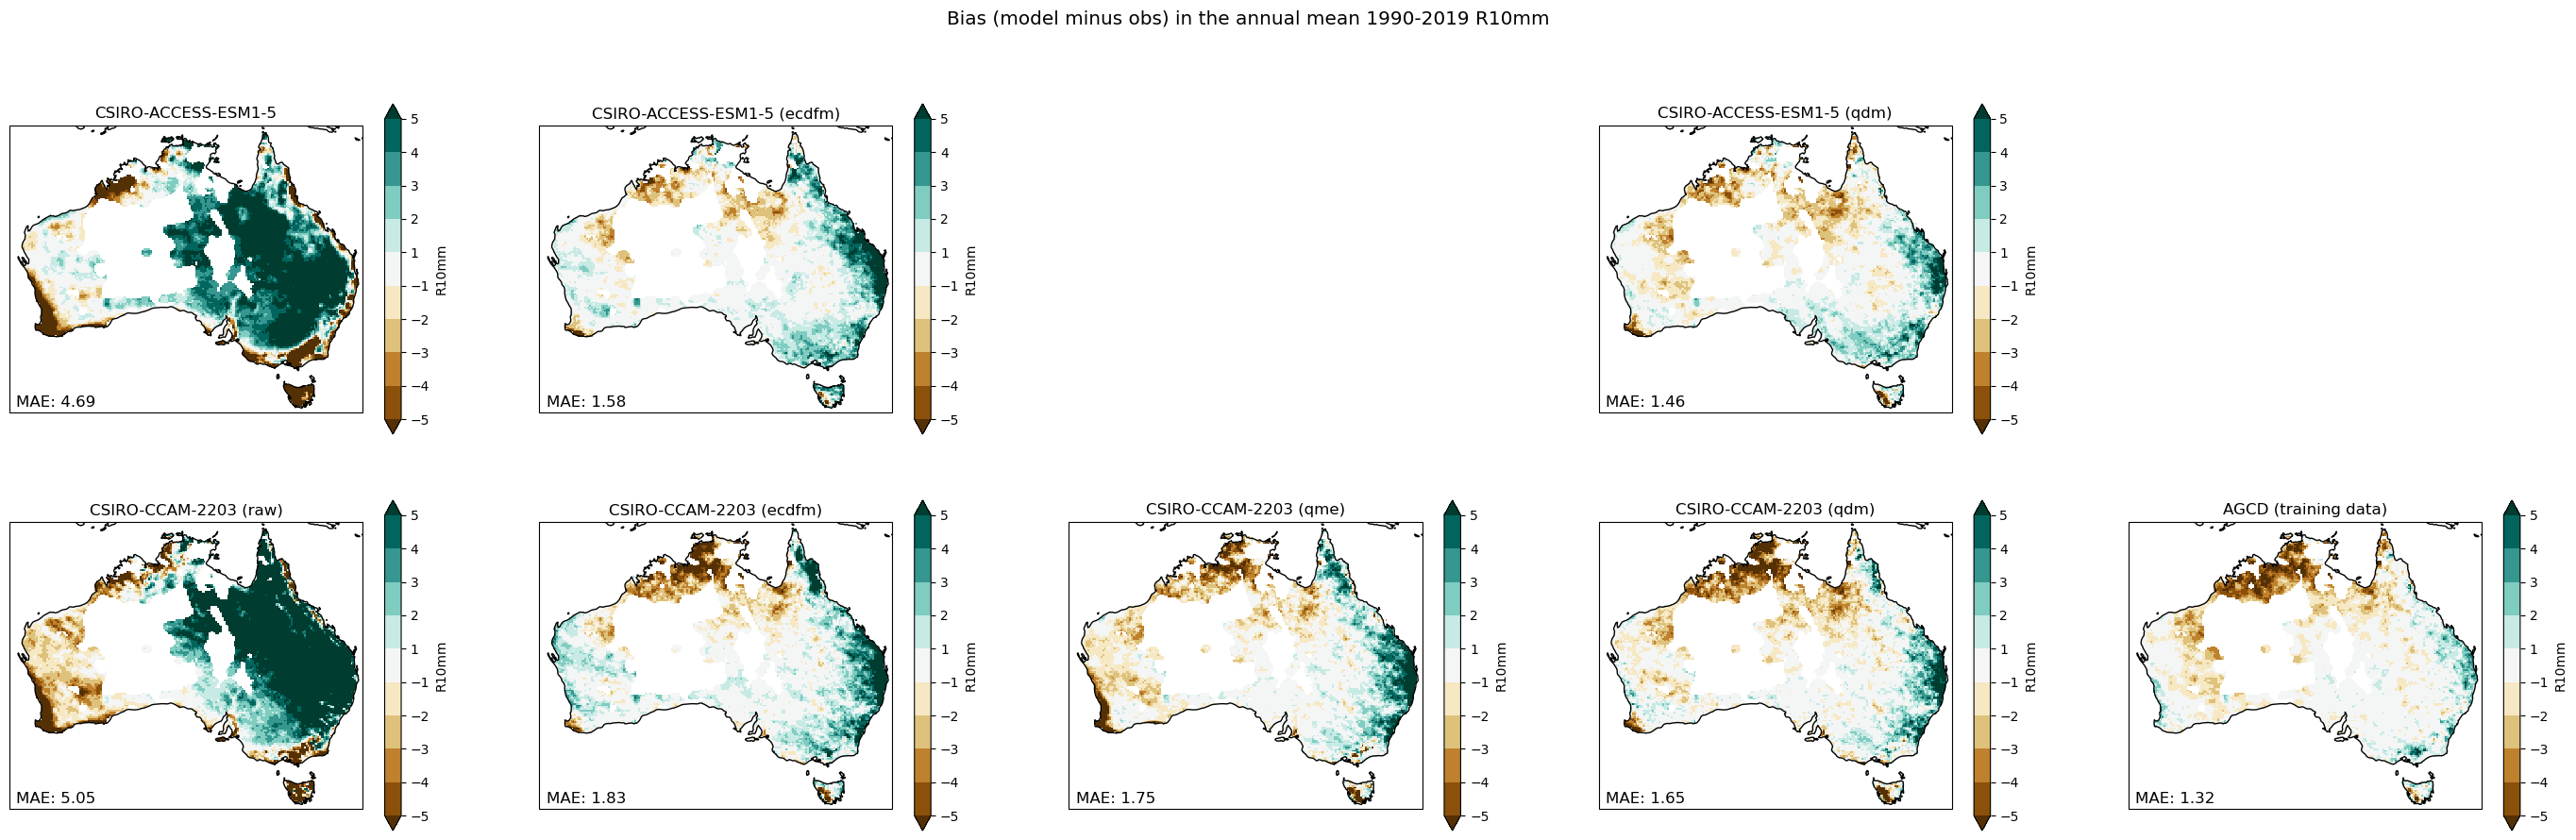

In [22]:
rcm = 'CSIRO-CCAM-2203'
plot_comparison(gcm, rcm, task, index, cmap=cmap_bias, levels=levels_bias)

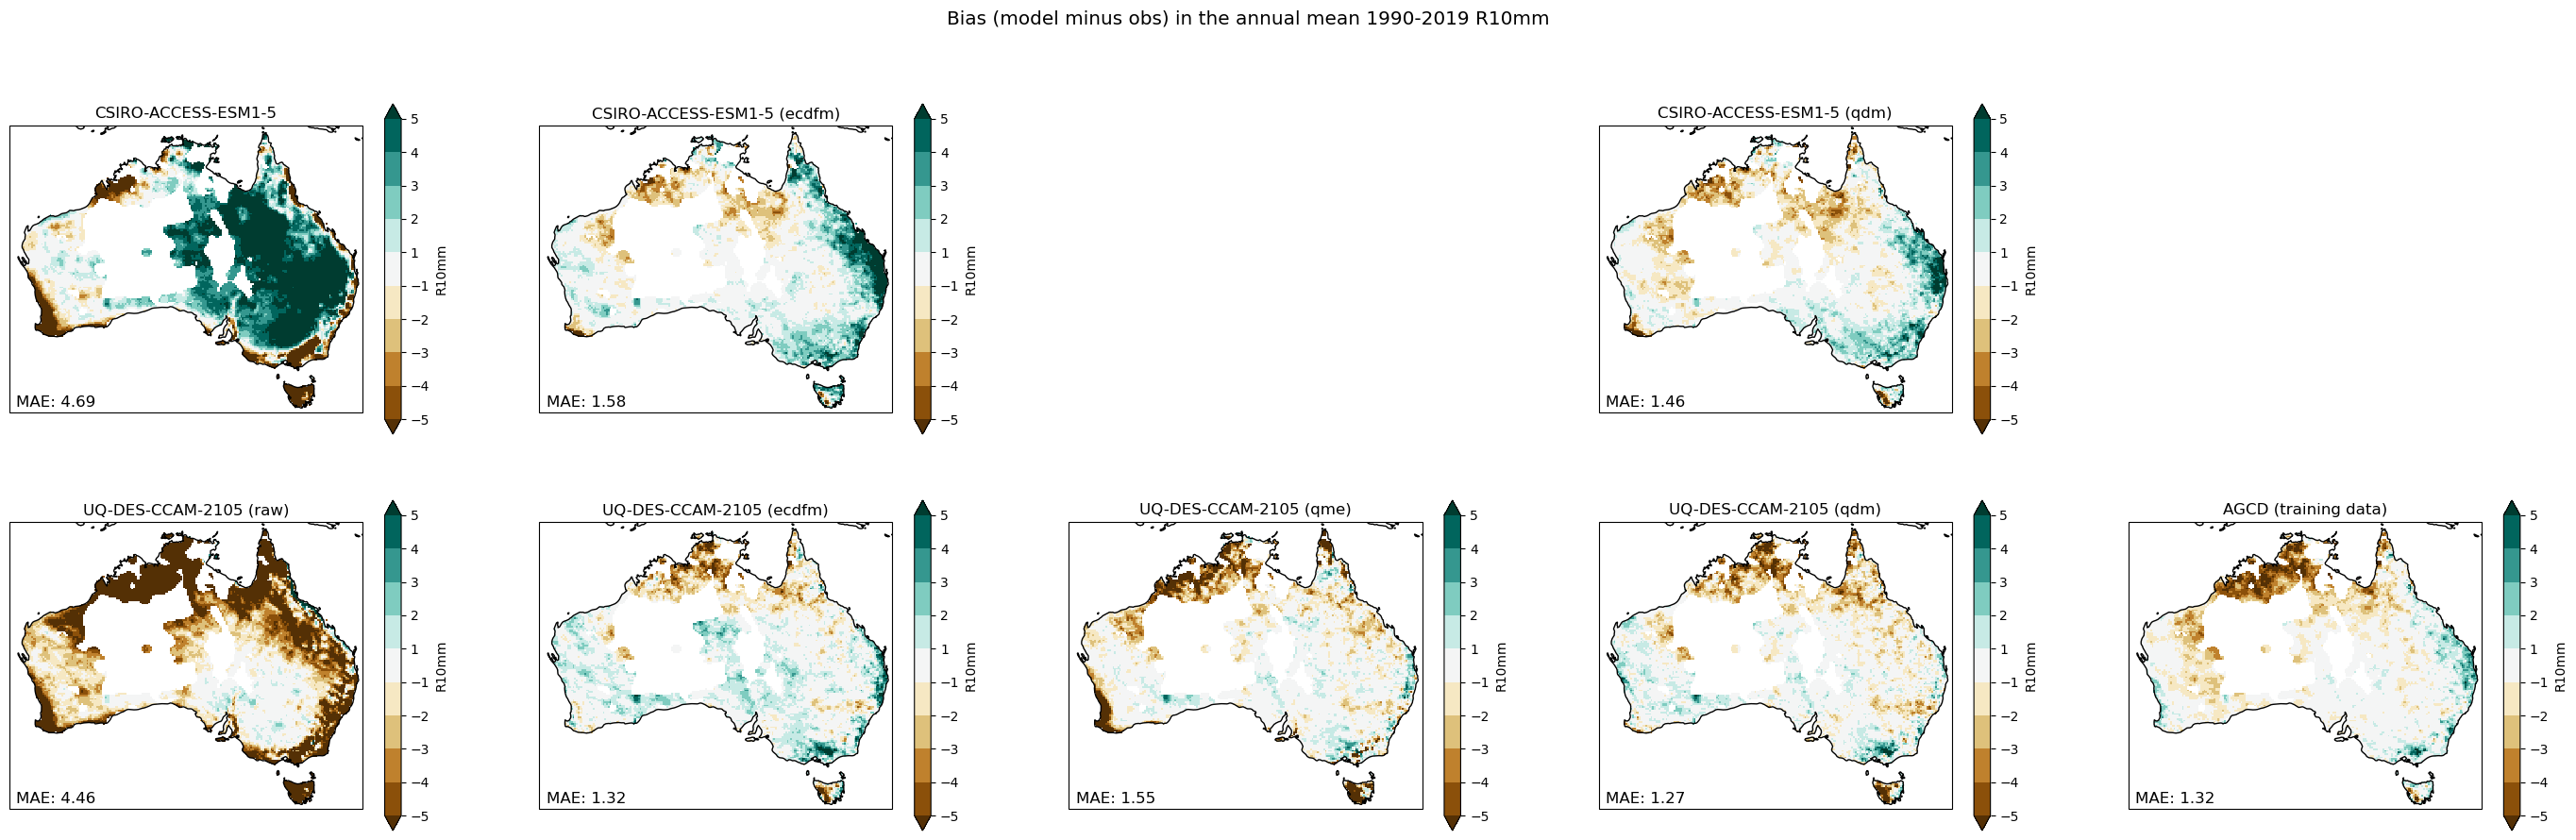

In [23]:
rcm = 'UQ-DES-CCAM-2105'
plot_comparison(gcm, rcm, task, index, cmap=cmap_bias, levels=levels_bias)